In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk
import re
import pickle as pkl
from collections import defaultdict, Counter
from html import unescape

In [2]:
from gensim import *
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import *
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
#import umap.umap_ as UMAP
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

In [4]:
df_sample = pd.read_csv("./data/clean_ref_ics_data_cleaned_lemmatized_sample.csv")

In [5]:
df_sample.shape[0]

4000

In [6]:
cols_for_analysis = ['lemmatized_1. Summary of the impact',
       'lemmatized_2. Underpinning research',
       'lemmatized_4. Details of the impact']

## LDA

In [60]:
summary = list([i.split(" ") for i in df_sample[cols_for_analysis[0]]])
bg = list([i.split(" ") for i in df_sample[cols_for_analysis[1]]])
detail = list([i.split(" ") for i in df_sample[cols_for_analysis[2]]])

In [123]:
text = [summary, bg, detail]

In [127]:

def lda_model(document,topicnum):
    dictionary = corpora.Dictionary()
    dictionary.add_documents(document)
    corpus = [dictionary.doc2bow(doc) for doc in document]
    lda = models.LdaModel(corpus=corpus, num_topics=topicnum, id2word=dictionary)
    keywords = lda.show_topics(num_words = 20)
    cm = models.CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    ch = cm.get_coherence()
    per=lda.log_perplexity(corpus)
    return lda, keywords, ch, per

def create_counter(document,lda):
    dictionary = corpora.Dictionary()
    dictionary.add_documents(document)
    corpus = [dictionary.doc2bow(doc) for doc in document]
    counter = []
    for doc in corpus: 
        p = lda[doc]
        p = sorted(p, key=lambda x: x[1], reverse=True)
        counter.append(p[0][0])
    return counter

In [71]:
def plot_metrics(topic_nums, coherence, perplexity, save_to = None):
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex = True)
    axs[0].plot(topic_nums, coherence)
    axs[1].plot(topic_nums, perplexity)
    axs[0].set_ylabel("Coherence")
    axs[1].set_ylabel("Perplexity")
    axs[0].set_xlabel("")
    axs[1].set_xlabel("Topic numbers")
    plt.tight_layout()
    if save_to is not None:
        fig.savefig(save_to)
    return

In [74]:
topic_nums = [30,35,40,45,50,55,60,65,70,75,80]
columns_for_lda = []

In [75]:
coherence = []
perplexity = []
all_keywords = []
for i in topic_nums:
    lda, keywords, ch, per = lda_model(summary,i)
    coherence.append(ch)
    perplexity.append(per)
    all_keywords.append(keywords)

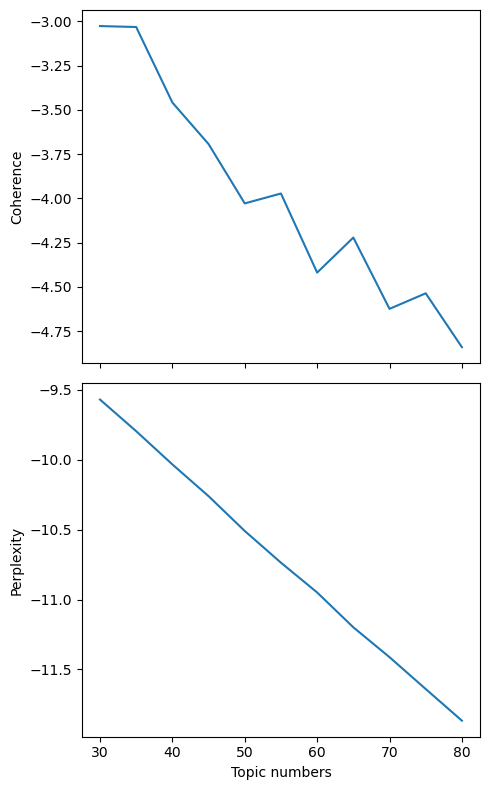

In [76]:
plot_metrics(topic_nums, coherence, perplexity, "./svg/lda_"+cols_for_analysis[0]+".svg")

In [77]:
coherence = []
perplexity = []
all_keywords = []
for i in topic_nums:
    lda, keywords, ch, per = lda_model(summary,i)
    coherence.append(ch)
    perplexity.append(per)
    all_keywords.append(keywords)

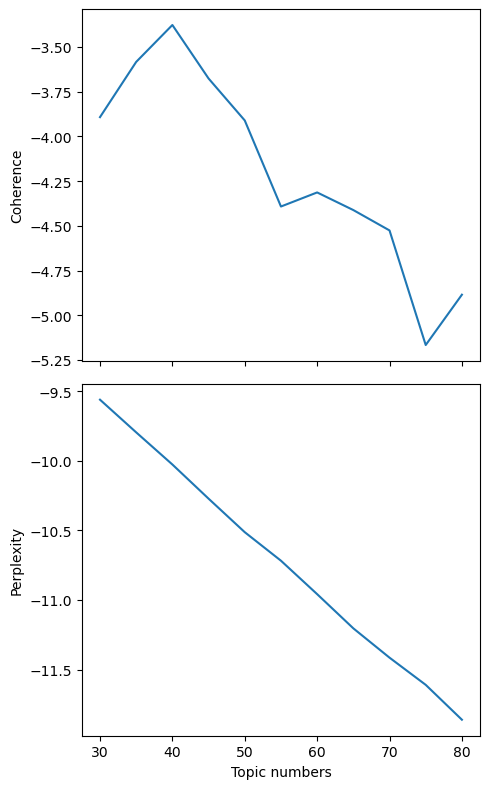

In [78]:
plot_metrics(topic_nums, coherence, perplexity, "./svg/lda_"+cols_for_analysis[1]+".svg")

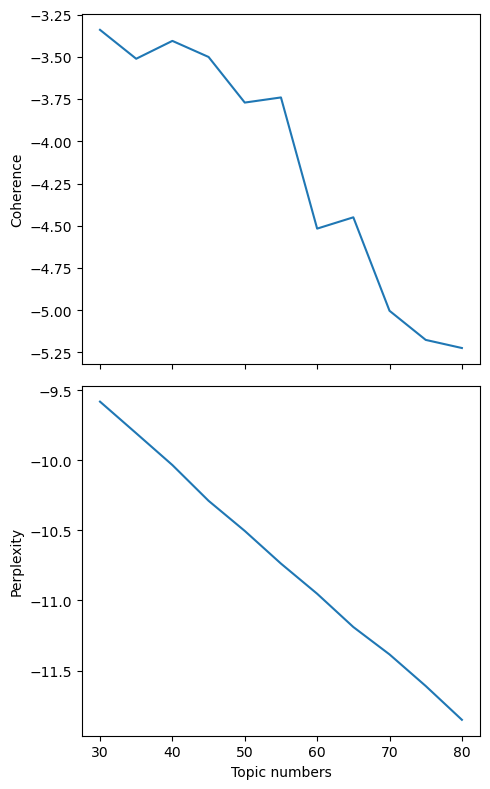

In [79]:
coherence = []
perplexity = []
all_keywords = []
for i in topic_nums:
    lda, keywords, ch, per = lda_model(summary,i)
    coherence.append(ch)
    perplexity.append(per)
    all_keywords.append(keywords)
plot_metrics(topic_nums, coherence, perplexity, "./svg/lda_"+cols_for_analysis[2]+".svg")

In [128]:
lda_summary, keywords, ch, per = lda_model(summary,35)

In [129]:
lda_bg, keywords, ch, per = lda_model(bg,40)

In [130]:
lda_detail, keywords, ch, per = lda_model(detail,45)

In [131]:
def get_max_topic(doc):
    return sorted(doc, key=lambda x: x[1], reverse=True)[0][0]

In [132]:
lda_results = df_sample[["case_id"]]
for i, lda_model in enumerate([lda_summary, lda_bg, lda_detail]):
    col_name = cols_for_analysis[i].split("_")[1]
    with open("./models/LDA_"+col_name+".pkl", "wb") as file:
        pkl.dump(lda_model, file)
    dictionary = corpora.Dictionary()
    dictionary.add_documents(text[i])
    results = [get_max_topic(i) for i in lda_model.get_document_topics([dictionary.doc2bow(doc) for doc in text[i]])]
    lda_results["LDA_topic_"+col_name] = results

In [134]:
lda_results.to_csv("ics_data_lda_original.csv", index = False)

### Visualize the topics

In [155]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [165]:
def create_vis(lda, corpus, original_text):
    dictionary = corpora.Dictionary()
    dictionary.add_documents(corpus)
    corpus = [dictionary.doc2bow(text) for text in corpus]
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    display(vis)
    return vis

In [206]:
summary_vis = create_vis(lda_summary, summary, df_sample[cols_for_analysis[0]])

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.020968 -0.065539       1        1  8.934274
0      0.068321 -0.032609       2        1  6.721979
21     0.116942 -0.017397       3        1  6.506813
16     0.018951  0.017215       4        1  4.672750
29    -0.100266 -0.132315       5        1  4.485881
19     0.056593 -0.020711       6        1  4.273505
8     -0.038216 -0.008830       7        1  4.095316
3      0.124943 -0.002963       8        1  3.890201
2      0.007856  0.011622       9        1  3.880721
23     0.012799 -0.035960      10        1  3.828201
5      0.008138 -0.058381      11        1  3.506200
18    -0.036437 -0.015771      12        1  3.405942
7      0.044948  0.032352      13        1  2.730918
15     0.011887 -0.032792      14        1  2.656558
4      0.071381  0.006946      15        1  2.541076
6     -0.007185 -0.032800      16        1  2.481413
17     0.011071 -0.034448      17        1  2.469017
27     0.003865  0.019641      18        1  2.390501
31    -0.093078 -0.011652      19        1  2.384370
22     0.025479 -0.050217      20        1  2.132339
30    -0.018588  0.017559      21        1  2.111117
20    -0.009091 -0.028453      22        1  1.974158
14    -0.098931 -0.023848      23        1  1.894071
32     0.016326  0.006253      24        1  1.809706
33    -0.044760 -0.007053      25        1  1.804322
1     -0.004442 -0.006728      26        1  1.668434
11     0.051173  0.061677      27        1  1.588004
9     -0.051437 -0.011130      28        1  1.350552
13    -0.039387  0.009956      29        1  1.339024
24    -0.045549  0.049263      30        1  1.305787
12     0.061386  0.044916      31        1  1.212200
28     0.049369  0.020110      32        1  1.168779
34    -0.049488  0.081704      33        1  1.078313
25    -0.003873  0.113779      34        1  0.901895
26    -0.099732  0.136604      35        1  0.805664, topic_info=              Term         Freq        Total Category  logprob  loglift
18          health  1211.000000  1211.000000  Default  30.0000  30.0000
511          sport   357.000000   357.000000  Default  29.0000  29.0000
158         public  2311.000000  2311.000000  Default  28.0000  28.0000
144       heritage   788.000000   788.000000  Default  27.0000  27.0000
78         patient   351.000000   351.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
8        community     8.281371  1325.494021  Topic35  -5.4456  -0.2543
24   international     8.010848  1369.949485  Topic35  -5.4789  -0.3205
16      government     7.677327  1368.733902  Topic35  -5.5214  -0.3621
31    organisation     7.399012  1078.557129  Topic35  -5.5583  -0.1608
846          trust     6.556880   247.833722  Topic35  -5.6791   1.1890

[2604 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1561     12  0.069007        abbey
1561     14  0.414043        abbey
1561     24  0.414043        abbey
9523     10  0.229894  aberystwyth
9523     29  0.689683  aberystwyth
...     ...       ...          ...
3951      4  0.079181     zimbabwe
3951     10  0.079181     zimbabwe
3951     14  0.079181     zimbabwe
3951     19  0.158363     zimbabwe
3951     33  0.475089     zimbabwe

[13825 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 22, 17, 30, 20, 9, 4, 3, 24, 6, 19, 8, 16, 5, 7, 18, 28, 32, 23, 31, 21, 15, 33, 34, 2, 12, 10, 14, 25, 13, 29, 35, 26, 27])

In [207]:
bg_vis = create_vis(lda_bg, bg, df_sample[cols_for_analysis[1]])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.015011 -0.083669       1        1  10.229092
24    -0.002912 -0.018318       2        1   8.275931
33    -0.085563 -0.011503       3        1   7.802076
14    -0.096602 -0.017160       4        1   6.825001
34    -0.030438 -0.012903       5        1   5.985750
26    -0.004004  0.004874       6        1   5.528214
11    -0.061492 -0.013212       7        1   4.912615
18    -0.007990 -0.009101       8        1   4.595464
10     0.056432  0.005722       9        1   3.510328
39    -0.037302 -0.038072      10        1   3.336472
15    -0.009900 -0.034572      11        1   3.224484
7      0.080206  0.002821      12        1   2.716589
20     0.041844 -0.051344      13        1   2.451110
23     0.017455  0.009705      14        1   2.342708
32     0.052155 -0.031528      15        1   2.172741
21     0.040797  0.001483      16        1   1.797775
35    -0.000336 -0.004470      17        1   1.607446
31     0.044532 -0.033519      18        1   1.602633
27     0.016386 -0.055177      19        1   1.600775
37    -0.049010 -0.011622      20        1   1.460335
4     -0.063187 -0.000701      21        1   1.399341
5      0.036666 -0.041933      22        1   1.370135
3     -0.038364  0.010041      23        1   1.350548
36    -0.057305  0.003541      24        1   1.307248
19    -0.008216  0.020754      25        1   1.144638
16     0.004047 -0.007549      26        1   1.120400
1      0.023654 -0.026949      27        1   1.086712
8     -0.026641  0.040705      28        1   1.051817
29    -0.078339  0.048341      29        1   0.911160
9      0.002420  0.012654      30        1   0.902664
22     0.026939 -0.016204      31        1   0.860236
38     0.021166  0.015732      32        1   0.787017
2     -0.035492  0.030339      33        1   0.758430
30     0.084462  0.013451      34        1   0.742210
0      0.001704  0.074106      35        1   0.700370
13     0.081171  0.076309      36        1   0.628863
28     0.010143  0.020545      37        1   0.587137
6     -0.025054  0.041703      38        1   0.522638
12     0.064570  0.044196      39        1   0.408835
25    -0.003615  0.042484      40        1   0.382059, topic_info=            Term         Freq        Total Category  logprob  loglift
859        child  3359.000000  3359.000000  Default  30.0000  30.0000
52        health  3425.000000  3425.000000  Default  29.0000  29.0000
99        policy  5020.000000  5020.000000  Default  28.0000  28.0000
1800  innovation  1149.000000  1149.000000  Default  27.0000  27.0000
2988         law  1568.000000  1568.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
747       design     8.084148  3040.089959  Topic40  -6.1966  -0.3624
694       system     7.808436  2505.363374  Topic40  -6.2313  -0.2036
105       public     7.722441  3868.976505  Topic40  -6.2423  -0.6493
71          life     7.573489  2097.261216  Topic40  -6.2618  -0.0564
294      support     7.634611  4015.354664  Topic40  -6.2538  -0.6978

[3097 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13299     20  0.711413          aa
13299     22  0.129348          aa
19392      6  0.165529         aat
19392     11  0.761434         aat
22575     21  0.913247       abbey
...      ...       ...         ...
848        4  0.048071    zimbabwe
848        5  0.240354    zimbabwe
848        8  0.048071    zimbabwe
848       30  0.384567    zimbabwe
7224      30  0.779701  zimbabwean

[22758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 25, 34, 15, 35, 27, 12, 19, 11, 40, 16, 8, 21, 24, 33, 22, 36, 32, 28, 38, 5, 6, 4, 37, 20, 17, 2, 9, 30, 10, 23, 39, 3, 31, 1, 14, 29, 7, 13, 26])

In [208]:
detail_vis = create_vis(lda_detail, detail, df_sample[cols_for_analysis[2]])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.109721 -0.024262       1        1  10.245148
2     -0.089135 -0.018384       2        1   6.002280
7     -0.037311  0.036542       3        1   5.296121
35     0.070855  0.003999       4        1   5.147025
21     0.062067 -0.023662       5        1   5.096336
3      0.026936 -0.041592       6        1   4.660270
18     0.010131 -0.022624       7        1   4.607884
25     0.030056  0.021459       8        1   4.278195
39    -0.082498 -0.024491       9        1   4.088799
32     0.057027  0.029870      10        1   3.771649
19    -0.012970  0.021616      11        1   3.433783
34     0.027540 -0.012386      12        1   3.390495
43    -0.009236  0.031068      13        1   2.872869
22    -0.059327  0.007532      14        1   2.765096
12     0.029139  0.103735      15        1   2.737336
0      0.079349 -0.050554      16        1   2.705130
16     0.056688  0.008657      17        1   2.422353
13    -0.064009  0.013671      18        1   2.385776
27     0.061717 -0.013845      19        1   2.257595
41     0.055892 -0.061183      20        1   1.864994
31     0.066771 -0.020057      21        1   1.770204
42     0.008224  0.053158      22        1   1.604427
30    -0.018824  0.017835      23        1   1.534615
17     0.003089 -0.008803      24        1   1.276049
14     0.002846  0.004035      25        1   1.213634
15    -0.012650 -0.019911      26        1   1.139887
38     0.026278 -0.016109      27        1   1.109058
20    -0.010598  0.017429      28        1   0.952363
4     -0.022182 -0.015400      29        1   0.946248
37     0.031084  0.002101      30        1   0.822360
6      0.017631 -0.007768      31        1   0.813707
11     0.004194  0.016829      32        1   0.728863
1      0.031243 -0.007524      33        1   0.697548
10    -0.112567 -0.022970      34        1   0.621111
23     0.001285 -0.009649      35        1   0.610588
36    -0.019459  0.000262      36        1   0.568716
28    -0.020642  0.005815      37        1   0.534616
5     -0.056840 -0.002905      38        1   0.495966
8      0.037756  0.016920      39        1   0.488887
44    -0.042043  0.006028      40        1   0.454848
40    -0.022810 -0.021914      41        1   0.431031
29     0.005781  0.008916      42        1   0.372283
33    -0.003556  0.010783      43        1   0.305777
26    -0.018612 -0.001447      44        1   0.295845
24     0.021411  0.009180      45        1   0.182238, topic_info=              Term          Freq         Total Category  logprob  loglift
144         policy  15370.000000  15370.000000  Default  30.0000  30.0000
700     exhibition   6794.000000   6794.000000  Default  29.0000  29.0000
839         school   8579.000000   8579.000000  Default  28.0000  28.0000
85          health   7593.000000   7593.000000  Default  27.0000  27.0000
151         public  12985.000000  12985.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
134   organisation      9.629799   5913.308750  Topic45  -6.0782  -0.1125
109            key      9.435939   5598.509379  Topic45  -6.0986  -0.0781
1916        design      9.005655   5206.015403  Topic45  -6.1452  -0.0521
325       guidance      8.513695   2779.580463  Topic45  -6.2014   0.5192
200           team      8.663404   5843.131320  Topic45  -6.1840  -0.2063

[3480 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
18977      1  0.102820  aardman
18977      3  0.771151  aardman
18977     14  0.051410  aardman
26535      2  0.067490      aat
26535      4  0.013498      aat
...      ...       ...      ...
12024      8  0.081069    zines
12024     23  0.040535    zines
12024     27  0.121604    zines
12024     44  0.526949    zines
32870     10  0.848867      zsl

[28109 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 

### Output keywords

In [221]:
def return_keywords(lda_model, vis_lda_model, lambd = 0.6): # Used because relevance metric will filter out common keywords like policy.
    all_topics = {}
    num_topics = lda_model.num_topics 
    num_terms = 20 

    for i in range(1,num_topics+1): ## Correct range
        topic = vis_lda_model.topic_info[vis_lda_model.topic_info.Category == 'Topic'+str(i)].copy()
        topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
        all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    keywords = pd.DataFrame(all_topics).T.reset_index()
    keywords.rename({"index":"topic_id"}, axis=1, inplace = True)
    return keywords

In [222]:
vises = [summary_vis, bg_vis, detail_vis]
lda_models = [lda_summary, lda_bg, lda_detail]
for i in range(3):
    keywords_lda = return_keywords(lda_models[i], vises[i])
    col_name = cols_for_analysis[i].split("_")[1]
    keywords_lda.to_csv("./models/LDA_keywords_"+col_name+".csv", index = False)
    

## BERT

In [7]:
def bert_model(col):
    representation_model = KeyBERTInspired()
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, representation_model=representation_model)
    topics, probs = topic_model.fit_transform(list(df_sample[col]))
    return topic_model

In [8]:
%%time
summary_bert = bert_model(cols_for_analysis[0])

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2023-06-08 01:09:29,303 - BERTopic - Transformed documents to Embeddings
2023-06-08 01:09:54,088 - BERTopic - Reduced dimensionality
2023-06-08 01:09:54,984 - BERTopic - Clustered reduced embeddings


CPU times: user 7min 56s, sys: 10.9 s, total: 8min 7s
Wall time: 1min 39s


In [9]:
%%time
bg_bert = bert_model(cols_for_analysis[1])

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2023-06-08 01:14:36,014 - BERTopic - Transformed documents to Embeddings
2023-06-08 01:14:57,013 - BERTopic - Reduced dimensionality
2023-06-08 01:14:57,993 - BERTopic - Clustered reduced embeddings


CPU times: user 24min 57s, sys: 5min 4s, total: 30min 2s
Wall time: 5min 18s


In [10]:
%%time
detail_bert = bert_model(cols_for_analysis[2])

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2023-06-08 01:19:38,574 - BERTopic - Transformed documents to Embeddings
2023-06-08 01:19:58,027 - BERTopic - Reduced dimensionality
2023-06-08 01:19:58,959 - BERTopic - Clustered reduced embeddings


CPU times: user 23min 43s, sys: 4min 46s, total: 28min 30s
Wall time: 5min 5s


In [34]:
## Save to file
bert_models = [summary_bert, bg_bert,detail_bert]
bert_results = df_sample[["case_id"]]
for i, model in enumerate(bert_models):
    col_name = cols_for_analysis[i].split("_")[1]
    bert_results["BERT_topic_"+col_name] = model.topics_
    bert_results["BERT_proba_"+col_name] = [max(i) for i in model.probabilities_]
    model.save("./models/BERT_original_"+col_name)

In [38]:
bert_results.to_csv("ics_data_bert_original.csv", index = False)

In [177]:
for i, model in enumerate(bert_models):
    col_name = cols_for_analysis[i].split("_")[1]
    keywords = pd.DataFrame.from_records(bg_bert.get_topics()).T.reset_index()
    keywords.rename({"index":"topic_id"}, axis=1, inplace = True)
    keywords.to_csv("./models/BERT_keywords_"+col_name+".csv", index = False)

### Examining topics

In [ ]:
summary_bert = BERTopic.load("./models/BERT_original_1. Summary of the impact")
bg_bert = BERTopic.load("./models/BERT_original_2. Underpinning research")
detail_bert = BERTopic.load("BERT_original_4. Details of the impact")

In [54]:
#Summay of impact
display(summary_bert.get_topic_info())

Topic  Count                                            Name
0      -1   1317       -1_practitioner_ngo_organisation_training
1       0    273           0_educator_teach_curriculum_education
2       1    151      1_healthcare_hospital_medical_organisation
3       2    139    2_heritage_archaeology_archaeological_museum
4       3    104             3_athletic_athlete_sport_paralympic
..    ...    ...                                             ...
63     62     12          62_suicidality_suicidal_suicide_morbid
64     63     11           63_airline_airport_transport_economic
65     64     10  64_bioethics_ethical_consultation_practitioner
66     65     10                     65_tariff_brexit_wto_policy
67     66     10     66_surveillance_security_government_privacy

[68 rows x 3 columns]

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



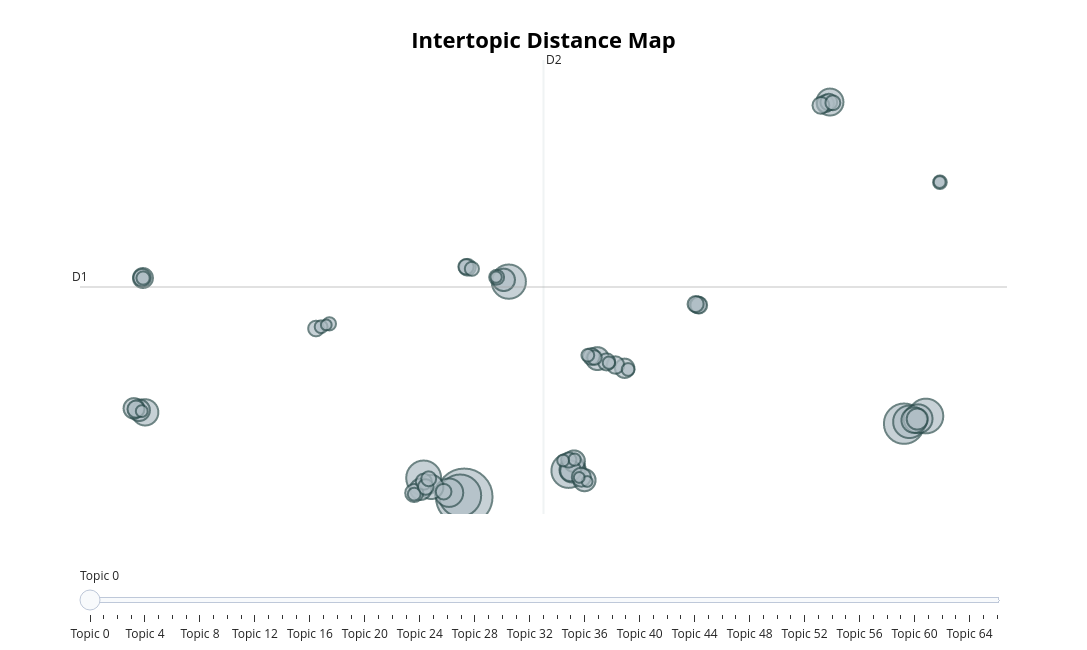

In [53]:
summary_bert.visualize_topics()

In [55]:
display(bg_bert.get_topic_info())

Topic  Count                                               Name
0      -1   1437         -1_community_heritage_collaboration_health
1       0    238            0_educator_curriculum_teacher_classroom
2       1    136  1_entrepreneur_enterprise_entrepreneurial_entr...
3       2    125                2_musician_music_musical_instrument
4       3    123            3_curatorial_artistic_sculpture_artwork
..    ...    ...                                                ...
59     58     12        58_islamophobia_islamism_muslimness_islamic
60     59     12                   59_textile_fashion_garment_craft
61     60     11  60_corruption_government_accountability_integrity
62     61     11             61_korea_geopolitical_communist_korean
63     62     10                 62_drug_opioids_overdoses_overdose

[64 rows x 3 columns]

In [56]:
display(detail_bert.get_topic_info())

Topic  Count                                         Name
0      -1   1433  -1_support_community_awareness_intervention
1       0    228         0_educator_teacher_teach_pedagogical
2       1    156       1_curatorial_exhibition_curator_museum
3       2    119             2_music_musician_musical_concert
4       3    112                3_athlete_compete_sport_coach
..    ...    ...                                          ...
69     68     12     68_outreach_volunteer_organisation_staff
70     69     12           69_fitness_assessment_health_sport
71     70     10   70_memorialisation_cultural_exhibit_legacy
72     71     10    71_pensioner_pension_retirement_portfolio
73     72     10              72_taxation_tax_fiscal_taxpayer

[74 rows x 3 columns]

## Semi-supervised BERT

In [18]:
categories = pd.read_csv("./data/unit_of_assessment.csv")

In [20]:
def bert_model_semi_supervised(col):
    representation_model = KeyBERTInspired()
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, representation_model=representation_model)
    topics, probs = topic_model.fit_transform(list(df_sample[col]), y=categories)
    return topic_model

In [21]:
summary_bert_semi = bert_model_semi_supervised(cols_for_analysis[0])

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2023-06-08 01:27:02,311 - BERTopic - Transformed documents to Embeddings
2023-06-08 01:27:21,295 - BERTopic - Reduced dimensionality
2023-06-08 01:27:22,157 - BERTopic - Clustered reduced embeddings


In [22]:
bg_bert_semi = bert_model_semi_supervised(cols_for_analysis[1])

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2023-06-08 01:31:26,724 - BERTopic - Transformed documents to Embeddings
2023-06-08 01:31:44,907 - BERTopic - Reduced dimensionality
2023-06-08 01:31:45,578 - BERTopic - Clustered reduced embeddings


In [23]:
detail_bert_semi = bert_model_semi_supervised(cols_for_analysis[2])

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

2023-06-08 01:36:01,356 - BERTopic - Transformed documents to Embeddings
2023-06-08 01:36:19,092 - BERTopic - Reduced dimensionality
2023-06-08 01:36:19,951 - BERTopic - Clustered reduced embeddings


In [24]:
bert_models_semi = [summary_bert_semi, bg_bert_semi,detail_bert_semi]
bert_results_semi = df_sample[["case_id"]]
for i, model in enumerate(bert_models_semi):
    col_name = cols_for_analysis[i].split("_")[1]
    bert_results_semi["BERT_topic_"+col_name] = model.topics_
    bert_results_semi["BERT_proba_"+col_name] = [max(i) for i in model.probabilities_]
    model.save("./models/BERT_semi_supervised_"+col_name)

In [26]:
bert_results_semi.to_csv("ics_data_bert_semi_supervised.csv", index = False)

In [33]:
for i, model in enumerate(bert_models_semi):
    col_name = cols_for_analysis[i].split("_")[1]
    keywords = pd.DataFrame.from_records(bg_bert.get_topics()).T.reset_index()
    keywords.rename({"index":"topic_id"}, axis=1, inplace = True)
    keywords.to_csv("./models/BERT_semi_supervised_keywords_"+col_name+".csv", index = False)

In [27]:
display(summary_bert_semi.get_topic_info())

Topic  Count                                               Name
0      -1    779          -1_ngo_healthcare_organisation_government
1       0    269             0_exhibition_curatorial_artwork_museum
2       1    236            1_educator_education_teacher_curriculum
3       2    236        2_centenary_commemoration_activism_heritage
4       3    216          3_legislation_advocacy_judiciary_judicial
..    ...    ...                                                ...
62     61     11                 61_heritage_tourism_tourist_museum
63     62     10              62_literacy_reading_reader_curriculum
64     63     10     63_cybersecurity_investigative_forensic_police
65     64     10  64_corruption_government_procurement_organisation
66     65     10  65_environment_environmental_building_architec...

[67 rows x 3 columns]

In [28]:
display(bg_bert_semi.get_topic_info())

Topic  Count                                               Name
0      -1    409           -1_support_intervention_health_community
1       0    496  0_organisational_enterprise_organisation_entre...
2       1    268                1_curatorial_artwork_artistic_craft
3       2    248            2_educator_curriculum_education_teacher
4       3    221          3_legislation_judicial_constitutional_law
5       4    206                    4_poet_literature_poetry_writer
6       5    181            5_commemoration_holocaust_irish_ireland
7       6    171                 6_fitness_sport_paralympic_athlete
8       7    149          7_resilience_disaster_stakeholder_climate
9       8    141             8_multilingual_welsh_linguistic_corpus
10      9    116                9_musician_music_musical_instrument
11     10    115        10_renewable_energy_sustainable_consumption
12     11     88           11_constituency_voter_electoral_election
13     12     82         12_psychiatric_suicidal_depression_suicide
14     13     68                13_cinema_filmmaking_film_filmmaker
15     14     67             14_theological_theology_clergy_secular
16     15     65                15_health_clinical_medical_medicine
17     16     57  16_archaeology_archaeological_neolithic_archae...
18     17     47                 17_dementia_disability_carers_care
19     18     46   18_stroke_rehabilitation_neurological_disability
20     19     45                   19_antiquity_roman_ancient_greek
21     20     43         20_agriculture_food_agricultural_livestock
22     21     37                       21_sex_hiv_sexual_prevalence
23     22     37             22_hospital_healthcare_hospice_medical
24     23     33                  23_adoption_welfare_poverty_adopt
25     24     31            24_health_adherence_routine_qualitative
26     25     29     25_journalism_journalist_humanitarian_lobbying
27     26     29                26_refugee_migrant_asylum_migration
28     27     29   27_neurodevelopmental_adoption_neonatal_maternal
29     28     26    28_shakespearean_shakespeare_playwright_theatre
30     29     23       29_theatre_audience_theatrical_participation
31     30     22                30_dancer_dance_ballet_choreography
32     31     22  31_peacekeeping_peacebuilding_reconciliation_m...
33     32     22     32_probation_criminology_rehabilitation_prison
34     33     22               33_transport_mobility_tourism_travel
35     34     22             34_slavery_slave_slaveholder_abolition
36     35     20     35_homelessness_homeless_housing_accommodation
37     36     20     36_constabulary_criminology_police_enforcement
38     37     19  37_ethnographic_indigenous_ethnography_anthrop...
39     38     18          38_torture_interrogation_peacekeeping_cia
40     39     18    39_heritage_collaboration_organisation_cultural
41     40     16                      40_syrian_diaspora_arab_syria
42     41     16             41_autism_autistic_disability_asperger
43     42     16             42_breastfeeding_maternal_fetal_infant
44     43     15                       43_lgbtq_lgbt_lgbtqi_lgbtqia
45     44     13     44_compliance_biomedicine_participate_societal
46     45     13  45_prejudice_multiculturalism_discrimination_i...
47     46     12    46_corruption_governance_government_procurement
48     47     12                47_literacy_reading_dyslexia_reader
49     48     12      48_banking_macroprudential_bank_macroeconomic
50     49     12        49_prisoner_prison_incarcerate_imprisonment
51     50     12                50_nuclear_nato_geopolitical_soviet
52     51     11          51_drug_overdose_decriminalisation_opioid
53     52     11                 52_tariff_economy_economic_trading
54     53     11         53_correctional_offender_probation_convict
55     54     10          54_monopoly_merger_regulatory_competitive

In [29]:
display(detail_bert_semi.get_topic_info())

Topic  Count                                               Name
0      -1   1209           -1_community_collaboration_support_staff
1       0    221                    0_poet_poetry_literature_writer
2       1    163                 1_athlete_sport_fitness_paralympic
3       2    154            2_educator_curriculum_teacher_classroom
4       3    136          3_commemoration_centenary_legacy_heritage
..    ...    ...                                                ...
68     67     12       67_organisation_government_policy_governance
69     68     12           68_obesity_consumption_alcohol_nutrition
70     69     11                  69_hunger_food_diet_participatory
71     70     11               70_practitioner_ukmed_medical_carers
72     71     10  71_organisational_organisation_management_lead...

[73 rows x 3 columns]

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



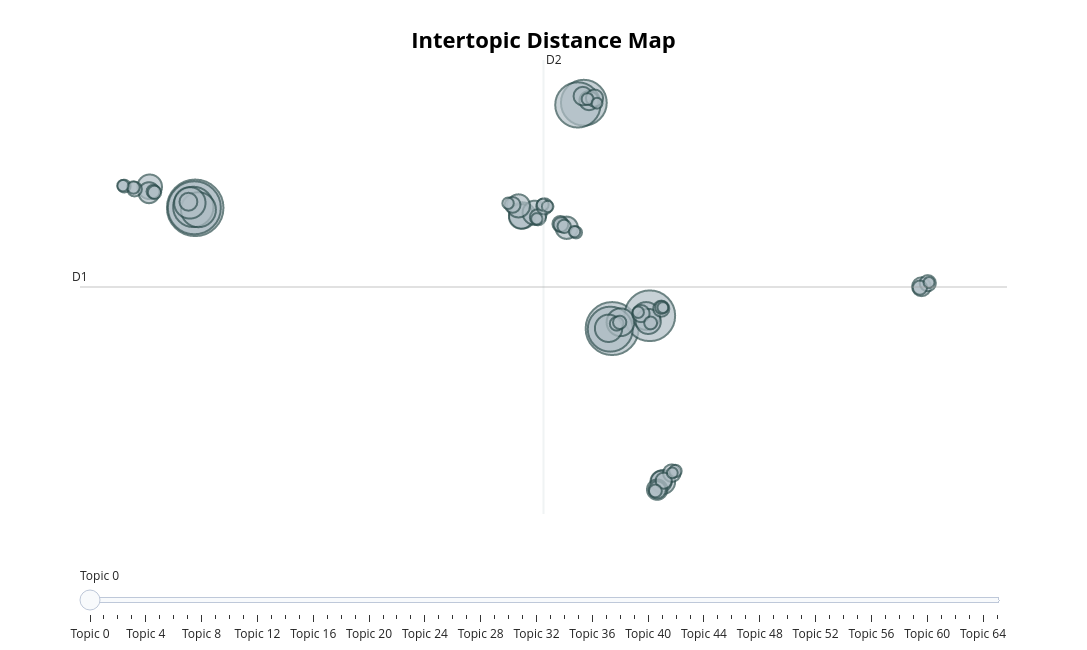

In [30]:
summary_bert_semi.visualize_topics()

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



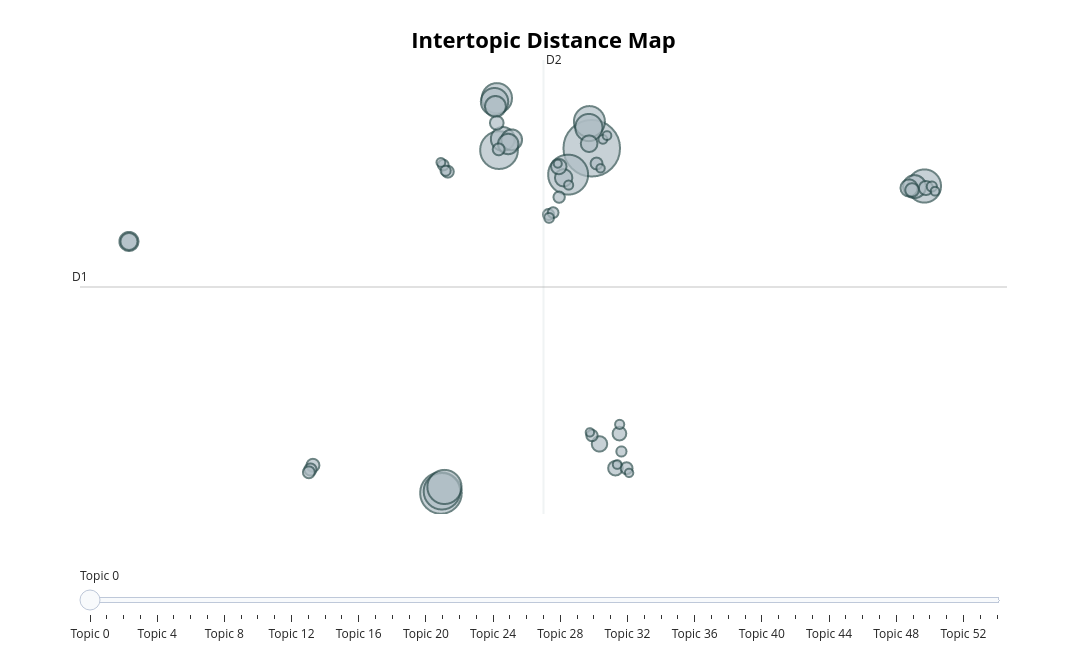

In [31]:
bg_bert_semi.visualize_topics()

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/lindali/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



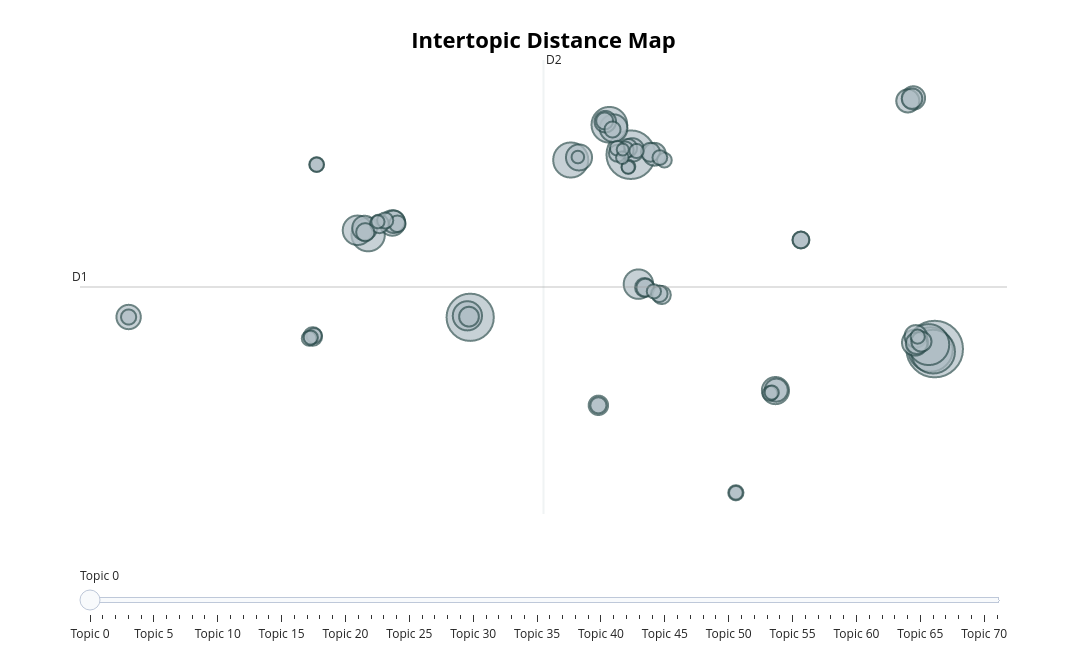

In [32]:
detail_bert_semi.visualize_topics()